In [1]:
import sys
sys.path.append('../..')
import numpy as np
import matplotlib.pyplot as plt
import random
import csv

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2

# DLBio and own scripts
from DLBio.pytorch_helpers import get_device
import ds_ear_siamese
import transforms_data as td
from helpers import cuda_conv
import metrics as M
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(epochs, value1, value2, label1, label2, plt_number):
    plt.figure(plt_number)
    plt.plot(epochs,value1, label=label1)
    plt.plot(epochs,value2, label=label2)
    plt.legend()
    plt.grid()

In [3]:
# Set Up All Configurations here
class Config():
    #1. Boolean ändern
    #2. FC-Layer auf Bild anpassen
    #3. LR auf 0,0005
    NN_SIAMESE = False
    dataset_dir = '../dataset/'
    #training_dir = "../data/ears/train/"
    #testing_dir = "../data/ears/test/"
    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 32
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS=50
    LEARNINGRATE = 0.0001
    #WEIGHT_DECAY = 0.0

    TRESHOLD_VER = 0.9
    is_small_resize = False

In [4]:
def check(p):
    return (p>=0 and p<=1)
def percentage_split(num_classes, train_percentage, valid_percentage, test_percentage):
    '''
    This function return the amount of classes to be chosen, given the actual amount and the percentages for
    the different sets
    Arguments
    ---------
    num_classes:    Amount of classes in dataset
    train_percentage:   Percentage of one, percentual size of train dataset
    valid_percentage:   Percentage of one, percentual size of validation dataset
    test_percentage:   Percentage of one, percentual size of test dataset. Can be Zero

    Returns
    ---------
    The amount of classes for train, validation and test dataset
    '''
    assert round(train_percentage+valid_percentage+test_percentage, 1)==1.0, "Percentages do not add up to 1"
    assert check(train_percentage) and check(valid_percentage) and check(test_percentage)

    train = round(num_classes * train_percentage)
    if test_percentage == 0:
        valid = num_classes-train
        test = test_percentage
    else:
        valid = round( (num_classes*valid_percentage) )
        test = num_classes-train-valid
    return train,valid,test

def diff(first, second):
    ''' computes the list diff
    '''
    second = set(second)
    return [item for item in first if item not in second]

In [5]:
# define indicies to split Data
dset = ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transformation=td.get_transform('size_only', is_small=Config.is_small_resize) )
N = len(dset)
classes = [dset.class_to_idx[class_] for class_ in dset.classes]
num_classes = len(classes)
print(N)

# Get amount of classes per set
tr,va,te = percentage_split(num_classes=num_classes,
                            train_percentage=0.7, 
                            valid_percentage=0.2,
                            test_percentage=0.1
                            )
# create class separation
train_classes = random.sample(classes, tr)
classes = diff(classes, train_classes)
valid_classes = random.sample(classes, va)
classes = diff(classes, valid_classes)
# Check if classes still has entries
if classes:
    test_classes = random.sample(classes, te)
    classes = diff(classes, test_classes)

train_indices, val_indices, test_indices = [],[],[]
# go through
for i,(_, class_idx) in enumerate(dset.imgs):
    if class_idx in train_classes:
        train_indices.append(i)
        continue
    if class_idx in valid_classes:
        val_indices.append(i)
        continue
    if class_idx in test_classes:
        test_indices.append(i)
        continue


['alexander_bec', 'alina_sch', 'alissa_buh', 'amanda_dab', 'anna_kab', 'anni_qua', 'beatrix_mah', 'clara_pau', 'clemens_blu', 'collin_sch', 'david_fau', 'falco_len', 'felix_mec', 'gregor_spi', 'hammam_als', 'janna_qua', 'janole_pen', 'jesse_kru', 'johannes_wie', 'jule_dre', 'julia_fis', 'konrad_von', 'lars_fin', 'linus_fal', 'lynn_man', 'maike_her', 'malte_gas', 'marcel_nim', 'marcus_jue', 'marejke_wen', 'marina_fri', 'marina_han', 'matilda_kni', 'meiko_pri', 'mila_wol', 'mohammed_muh', 'moritz_bor', 'moritz_mei', 'nils_loo', 'pauline_bus', 'robert_kle', 'robert_sch', 'sarah_amo', 'sarah_feh', 'sina_jun', 'tim_moe', 'yannik_obe']
3760


In [6]:
# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    transformation=td.get_transform('siamese', is_small=Config.is_small_resize),
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    should_invert = False
)

val_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=val_indices,
    transformation=td.get_transform('siamese_valid_and_test', is_small=Config.is_small_resize),
    batch_size=Config.val_batch_size,
    num_workers=Config.num_workers,
    should_invert = False
)

test_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=test_indices,
    transformation=td.get_transform('siamese_valid_and_test', is_small=Config.is_small_resize),
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    should_invert = False
)
vis_dataloader = ds_ear_siamese.get_dataloader(
    data_path=Config.dataset_dir,
    indices=train_indices,
    transformation=td.get_transform('siamese', is_small=Config.is_small_resize),
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    should_invert = False
)

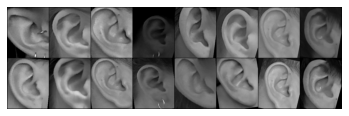

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [7]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [8]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    #model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=42)
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])
    
    # layers = []
    
    # for layer in model.features[0]:
    #     layers.append(layer)
    # model.features[0][0] = nn.ReflectionPad2d(1)
    # model.features[0][1] = layers[0]
    # model.features[0][2] = layers[1]
    # model.features[0].add_module('3', layers[2])

    #list(model.features[2].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[3].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[6].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[8].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[10].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[12].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[14].children())[0].add_module('4', nn.Dropout2d(0.4))
    #list(model.features[16].children())[0].add_module('4', nn.Dropout2d(0.4))
   


else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss(2.0)
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


In [9]:
#To Define which Layers we want to train
# for param in model.parameters():
#     param.requires_grad = False

# sub_layer = list(model.features.children())
# unfreezed = [14,15,16,17,18]
# for u in unfreezed:
#     for param in sub_layer[u].parameters():
#         param.requires_grad = True

In [10]:
# To show trainable parameters
from DLBio.pytorch_helpers import get_num_params

get_num_params(model,True)

2223296

Epoch number 0
 Current loss 32.1047
 Current acc 49.40
 Current val_loss 2.5725
 Current val_acc 51.09

Epoch number 1
 Current loss 1.8882
 Current acc 48.49
 Current val_loss 0.9487
 Current val_acc 57.07

Epoch number 2
 Current loss 1.0667
 Current acc 49.85
 Current val_loss 0.7018
 Current val_acc 67.12

Epoch number 3
 Current loss 0.9076
 Current acc 56.10
 Current val_loss 0.6865
 Current val_acc 73.10

Epoch number 4
 Current loss 0.8197
 Current acc 60.43
 Current val_loss 0.6833
 Current val_acc 77.31

Epoch number 5
 Current loss 0.7648
 Current acc 65.25
 Current val_loss 0.6225
 Current val_acc 78.80

Epoch number 6
 Current loss 0.7062
 Current acc 69.35
 Current val_loss 0.5951
 Current val_acc 83.56

Epoch number 7
 Current loss 0.6567
 Current acc 73.72
 Current val_loss 0.5558
 Current val_acc 83.83

Epoch number 8
 Current loss 0.6250
 Current acc 76.09
 Current val_loss 0.5674
 Current val_acc 84.92

Epoch number 9
 Current loss 0.5976
 Current acc 77.71
 Current

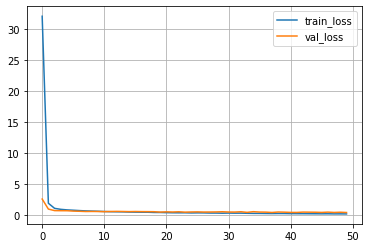

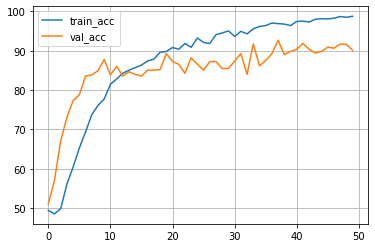

In [11]:
# opening the file with w+ mode truncates the file (clear file before training)
f = open('log_dist_label.csv', 'w+')
f.close()

training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE, THRESHOLD=Config.TRESHOLD_VER)

epochs, loss_history, val_loss_history, acc_history, val_acc_history = training(Config.EPOCHS)
show_plot(epochs, loss_history, val_loss_history,'train_loss', 'val_loss',1)
show_plot(epochs, acc_history, val_acc_history,'train_acc', 'val_acc', 2)

In [ ]:
#epochs = epochs[1:]
#loss_history = loss_history[1:]
#val_loss_history = val_loss_history[1:]
#show_plot(epochs, loss_history, val_loss_history,'train_loss', 'val_loss',1)

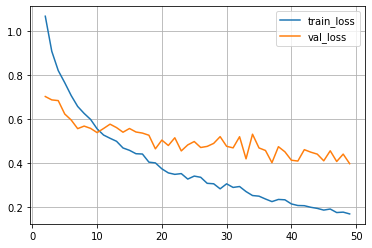

In [12]:
def calc_thresh():
    with open('log_dist_label.csv', 'r') as f:
        reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
        # data = list(reader)
        data = [tuple(row) for row in reader]

        thresh_same, thresh_diff = [], []
        for thresh,label in data:
            if label == 0: thresh_same.append(thresh) # Images came from same person
            else: thresh_diff.append(thresh)
        average_thresh_same = sum(thresh_same) / len(thresh_same)
        average_thresh_diff = sum(thresh_diff) / len(thresh_diff)
        print("Average dist different: ", average_thresh_diff)
        print('Amount of "same" distances: ', len(thresh_same))
    return average_thresh_same

print("Average dist same: ", calc_thresh())

Average dist different:  2.0447438341404065
Amount of "same" distances:  66057
Average dist same:  0.8045639499486835


In [13]:
# tn Bilder nicht gleich, Distanz größer als THRESH
# fp Bilder nicht gleich, Distanz kleiner als THRESH
# fn Bilder gleich, Distanz größer als THRESH
# tp Bilder gleich, Distanz kleiner als THRESH

def calc_test_label(thresh=Config.TRESHOLD_VER):
    '''
    This function processes the test dataloader and returns the true labels and the predicted labels (depending on a threshold)
    Arguments
    ---------
    thresh:     Threshold for "same-different" classification
                default is the Config set threshhold
                

    Returns
    ---------
    Two lists of same length as image tuples in test loader with labels 1 or 0
    '''
    ground_truth_label, prediction_label = [], []

    for data in test_dataloader:
        # use training class for data extraction
        label, output1, output2 = training.get_label_outputs(data)
        # extend labels of the ground truth
        ground_truth_label.extend(label.flatten().tolist())
        # Extend the distance-threshold prediction
        prediction_label.extend(M.batch_predictions_bin(output1, output2, thresh))
    # lists containing all image tuple labels or predictions
    return ground_truth_label, prediction_label

ground_truth, prediction = calc_test_label(Config.TRESHOLD_VER)
# get confusion matrix
cf = M.cf_matrix(ground_truth, prediction)

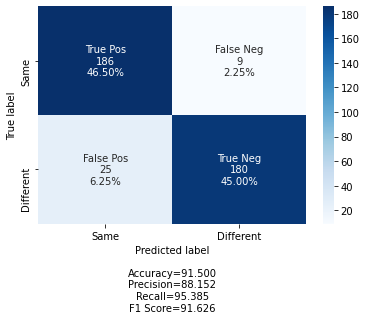

In [14]:
# Set parameters for confusion_matrix plot
labels = ['True Pos','False Neg','False Pos','True Neg']
categories = ['Same', 'Different']

# plot matrix
M.make_confusion_matrix(cf,
                        group_names=labels,
                        categories=categories,
                        cbar=True
                        )

In [15]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [17]:
#torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/ve_r_9891.pt')